In [3]:
from glob import glob
import json
import tqdm

In [4]:
files = glob('./selected_questions/*.jsonl')
questions = []
for path in files:
    question_type = path[path.rfind('/')+1:-6]
    with open(path, 'r') as file:
        for i in range(100):
            line = file.readline()
            question = json.loads(line)
            question['type'] = question_type
            questions.append(question)

In [9]:
import psycopg
from psycopg.rows import dict_row

def run_sql(sql, conn):
    cur = conn.cursor()
    cur.execute(sql)
    records = cur.fetchall()
    cur.close()
    return {'output': [{k: row[k] for k in row if row[k] is not None} for row in records], 'error': ''}


In [11]:
conn = psycopg.connect(
    host = 'localhost',
    dbname = 'osm_ca',
    user = 'postgres',
    password = 'postgres',
    port = 5432,
    row_factory=dict_row,
)

import time

sql_output = []
progress = tqdm.tqdm(range(len(questions)))
for i in progress:
    q = questions[i]
    start_time = time.time()
    run_sql(q['sql'], conn)
    end_time = time.time()
    sql_output.append([{'id': q['id'], 'type': q['type'], 'time': end_time-start_time}])
conn.close()

100%|██████████| 2800/2800 [2:01:57<00:00,  2.61s/it]    


In [17]:
import pandas as pd

ids = []
types = []
times = []
for t in sql_output:
    t=t[0]
    ids.append(t['id'])
    types.append(t['type'])
    times.append(t['time'])

df = pd.DataFrame({'id': ids, 'type': types, 'time':times})

In [19]:
df.to_csv('./sql_answers_time.csv')

In [25]:
df.groupby('type')['time'].agg(['min', 'max', 'mean'])

,min,max,mean
type,,,
intersects+count,0.223813,4.760844,0.964419
intersects:area_max+name,0.050383,77.546881,12.265172
intersects:area_total+area,0.044119,55.064989,12.378839
intersects:length_max+name,0.044478,1649.242660,20.912673
intersects:length_total+length,0.039948,1645.304906,19.870562
knn+angle,0.078850,0.179754,0.103613
knn+distance,0.074801,0.187057,0.096399
knn+loc,0.075589,0.175823,0.098596
knn+name,0.076176,0.182024,0.103598


In [28]:
df.sort_values(by='time')

,id,type,time
2205,1505,intersects:length_total+length,0.039948
622,2122,intersects:area_total+area,0.044119
1145,1745,intersects:length_max+name,0.044478
1477,1977,intersects:area_max+name,0.050383
606,2106,intersects:area_total+area,0.050724
...,...,...,...
1167,1767,intersects:length_max+name,88.803250
2258,1558,intersects:length_total+length,118.861305
1160,1760,intersects:length_max+name,122.127231
2279,1579,intersects:length_total+length,1645.304906


In [68]:
conn = psycopg.connect(
    host = 'localhost',
    dbname = 'osm_ca',
    user = 'postgres',
    password = 'postgres',
    port = 5432,
    row_factory=dict_row,
)

records  = run_sql('''
  SELECT
    ST_AsText(geometry) AS original_geom,
    ST_AsText(ST_OffsetCurve(geometry::geometry, 0.001)) AS offset_left,
    ST_AsText(ST_OffsetCurve(geometry::geometry, -0.001)) AS offset_right
  FROM
    roads
LIMIT 1;
''', conn)

conn.close()

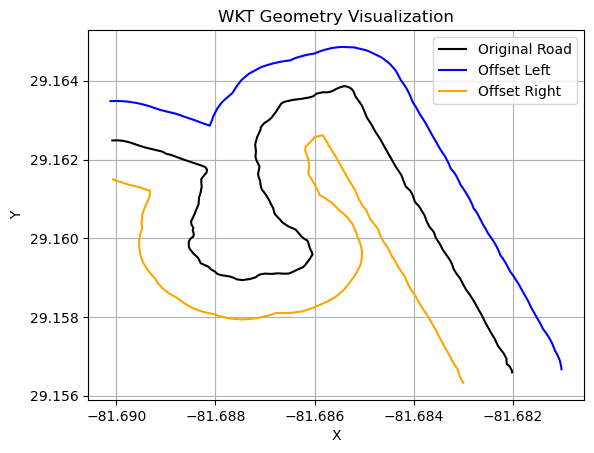

In [69]:
from shapely import wkt
import matplotlib.pyplot as plt

l1 = wkt.loads(records['output'][0]['original_geom'])
l2 = wkt.loads(records['output'][0]['offset_left'])
l3 = wkt.loads(records['output'][0]['offset_right'])

fig, ax = plt.subplots()

# Plot geometries
x, y = l1.xy
ax.plot(x, y, label="Original Road", color="black")

# for _l in l2.geoms:
x, y = l2.xy
ax.plot(x, y, label="Offset Left", color="blue")


x, y = l3.xy
ax.plot(x, y, label="Offset Right", color="orange")

# Customize plot
ax.legend()
ax.set_title("WKT Geometry Visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.grid()
plt.show()


In [72]:
conn = psycopg.connect(
    host = 'localhost',
    dbname = 'osm_ca',
    user = 'postgres',
    password = 'postgres',
    port = 5432,
    row_factory=dict_row,
)

records  = run_sql('''
SELECT ST_AsText(ST_MakePolygon(ST_Union(
    geometry::geometry, 
    ST_OffsetCurve(geometry::geometry, 0.001)
))) AS merged_polygon
FROM roads
LIMIT 1;''', conn)

conn.close()

InternalError_: Shell is not a line